Importación de librerías

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import pickle
from datetime import datetime


Carga y preparación de los datos

In [ ]:
# Cargar dataset
df = pd.read_csv("../data/processed/online_news_modified_engineered_processed_20251010.csv")

# Limpieza de columnas
df.columns = [c.strip() for c in df.columns]
num_cols = [c for c in df.columns if c != "url"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# Asegurar shares válido
if df["shares"].isna().any():
    df = df.dropna(subset=["shares"])

# Orden temporal
if "timedelta" in df.columns:
    df["timedelta"] = pd.to_numeric(df["timedelta"], errors="coerce")
    df = df.dropna(subset=["timedelta"]).sort_values("timedelta").reset_index(drop=True)
else:
    df = df.reset_index(drop=True)

# Variable objetivo binaria
D1 = 1400
df["popular"] = (df["shares"] > D1).astype(int)

# Features y target
drop_cols = ["shares", "popular"]
if "url" in df.columns:
    drop_cols.append("url")
X = df.drop(columns=drop_cols)
y = df["popular"]



Separación temporal

In [3]:
n = len(df)
train_end = int(n * 0.70)
valid_end = int(n * 0.85)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_valid, y_valid = X.iloc[train_end:valid_end], y.iloc[train_end:valid_end]
X_test,  y_test  = X.iloc[valid_end:], y.iloc[valid_end:]


Función auxiliar para threshold óptimo

In [4]:
def pick_thr_f1(y_true, proba, grid=np.linspace(0.15, 0.85, 141)):
    """Selecciona el umbral que maximiza F1 de la clase positiva"""
    best, best_thr = -1, 0.5
    for t in grid:
        pred = (proba >= t).astype(int)
        sc = f1_score(y_true, pred, pos_label=1)
        if sc > best:
            best, best_thr = sc, t
    return best_thr


Función de entrenamiento y evaluación con RF

In [5]:
def train_eval_rf(params, X_train, y_train, X_valid, y_valid, X_test, y_test):
    """Entrena un Random Forest y devuelve métricas de valid/test."""
    rf = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    # Probabilidades
    p_val = rf.predict_proba(X_valid)[:,1]
    p_tst = rf.predict_proba(X_test)[:,1]
    
    # Umbral óptimo en validación
    thr_val = pick_thr_f1(y_valid, p_val)
    
    # Métricas
    auc_val = roc_auc_score(y_valid, p_val)
    auc_tst = roc_auc_score(y_test, p_tst)
    f1_tst  = f1_score(y_test, (p_tst >= thr_val).astype(int))
    
    return {
        "model": rf,
        "auc_valid": auc_val,
        "auc_test": auc_tst,
        "f1_test": f1_tst,
        "thr_from_valid": thr_val
    }


Definición de rejilla de hiperparámetros

In [6]:
param_grid = {
    "n_estimators": [100],
    "max_depth": [10, None],
    "max_features": ["sqrt"],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}


Grid Search Manual

In [7]:
results = []
models = []

for g in ParameterGrid(param_grid):
    res = train_eval_rf(g, X_train, y_train, X_valid, y_valid, X_test, y_test)
    results.append({**g, **res})
    models.append(res["model"])

results_df = pd.DataFrame(results).sort_values(["auc_valid","auc_test"], ascending=False).reset_index(drop=True)
print(results_df.head(10))


   max_depth max_features  min_samples_leaf  min_samples_split  n_estimators  \
0       10.0         sqrt                 1                  5           100   
1       10.0         sqrt                 2                  5           100   
2       10.0         sqrt                 1                  2           100   
3       10.0         sqrt                 2                  2           100   
4        NaN         sqrt                 2                  5           100   
5        NaN         sqrt                 1                  2           100   
6        NaN         sqrt                 1                  5           100   
7        NaN         sqrt                 2                  2           100   

                                               model  auc_valid  auc_test  \
0  (DecisionTreeClassifier(max_depth=10, max_feat...   0.681991  0.626754   
1  (DecisionTreeClassifier(max_depth=10, max_feat...   0.681679  0.628609   
2  (DecisionTreeClassifier(max_depth=10, max_fea

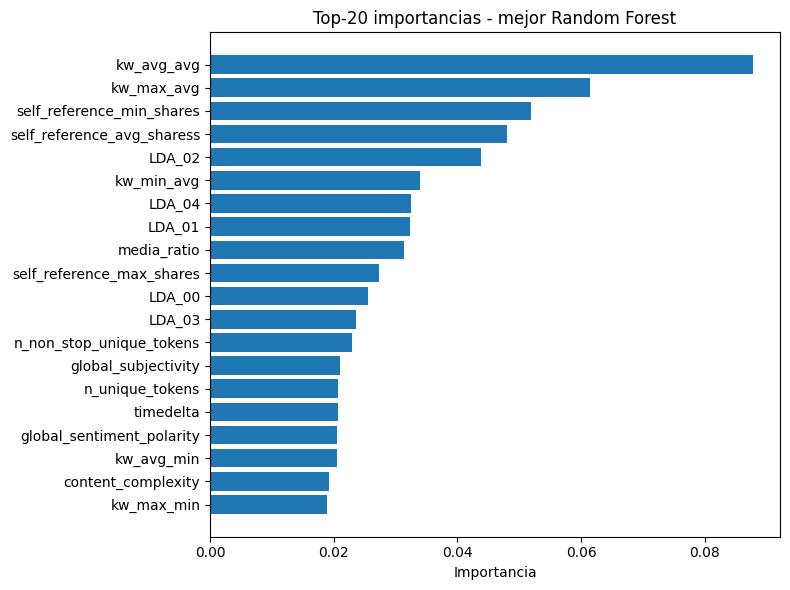

In [8]:
best_rf = models[0]
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,6))
plt.barh(X.columns[indices[:20]], importances[indices[:20]])
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.title("Top-20 importancias - mejor Random Forest")
plt.tight_layout()
plt.show()


In [10]:
# Seleccionar la mejor fila de resultados
best_row = results_df.iloc[0]

# Asegurar tipos correctos para los hiperparámetros
best_params = {
    "n_estimators": int(best_row["n_estimators"]),
    "max_depth": None if pd.isna(best_row["max_depth"]) else int(best_row["max_depth"]),
    "max_features": best_row["max_features"],  # puede ser 'sqrt', 'log2' o float
    "min_samples_split": int(best_row["min_samples_split"]),
    "min_samples_leaf": int(best_row["min_samples_leaf"])
}

# Umbral óptimo obtenido en validación
best_thr = float(best_row["thr_from_valid"])

# Entrenar con train + valid
X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

final_rf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
final_rf.fit(X_train_full, y_train_full)

# Predicciones finales en test
proba_test_final = final_rf.predict_proba(X_test)[:,1]
auc_test_final = roc_auc_score(y_test, proba_test_final)
y_pred_test_final = (proba_test_final >= best_thr).astype(int)

# Reporte de métricas
print(f"AUC_test(final): {auc_test_final:.3f}  | thr(use valid): {best_thr:.3f}")
print(classification_report(y_test, y_pred_test_final, digits=3))
print(confusion_matrix(y_test, y_pred_test_final))



AUC_test(final): 0.633  | thr(use valid): 0.365
              precision    recall  f1-score   support

           0      0.625     0.203     0.306      2695
           1      0.586     0.903     0.711      3371

    accuracy                          0.592      6066
   macro avg      0.605     0.553     0.508      6066
weighted avg      0.603     0.592     0.531      6066

[[ 546 2149]
 [ 328 3043]]


In [12]:
model_package = {
    "model": final_rf,
    "params": best_params,
    "threshold": best_thr,
    "criterion": "auc_test",
    "timestamp": datetime.now().isoformat(timespec="seconds")
}

current_dir = os.getcwd()
model_name = "01_rf_CDC.pkl"
model_path = os.path.join(current_dir, model_name)

with open(model_path, "wb") as f:
    pickle.dump(model_package, f)

print(f"Modelo guardado en la misma carpeta del notebook: {model_path}")

Modelo guardado en la misma carpeta del notebook: /home/emiluna/MLOps/MLOps_Course_Project/notebooks/01_rf_CDC.pkl
